In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [7]:
df= pd.read_csv('../input/gochu1/gochu(lstm).csv',encoding='cp949')
df.head()

,date,ondo,sun,snow,price
0,2015-01-04,-1.9,7.48,0.1,4807
1,2015-01-05,-1.1,7.04,0.3,4717
2,2015-01-06,-1.7,10.48,0.0,4667
3,2015-01-07,-8.7,9.97,0.0,4623
4,2015-01-08,-8.9,10.08,0.0,4504


In [8]:
sun=df['sun']
ondo=df['ondo']
snow=df['snow']
price=df['price']
date=['date']

Text(0.5, 1.0, 'price')

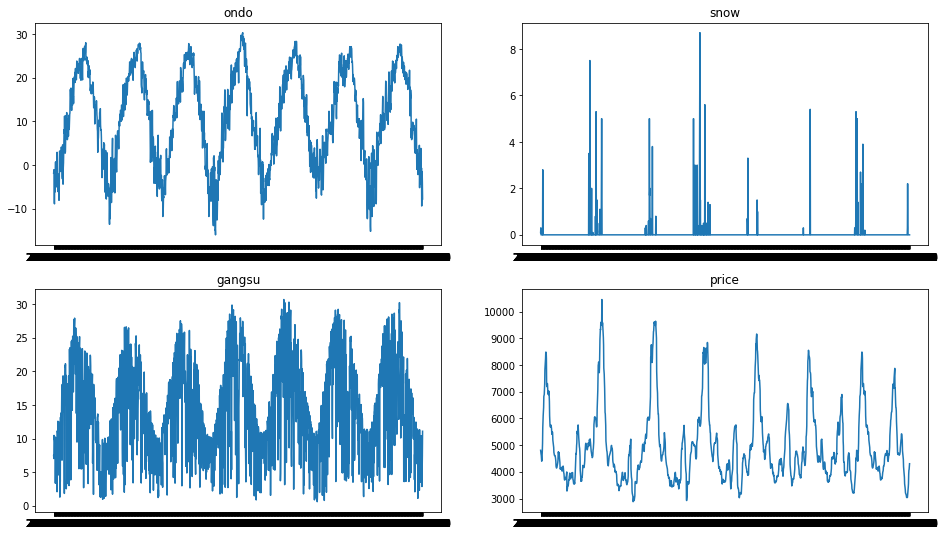

In [9]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.plot(df['date'], df['ondo'],label='ondo')
plt.title('ondo')

plt.subplot(222)
plt.plot(df['date'], df['snow'],label='uga')
plt.title('snow')

plt.subplot(223)
plt.plot(df['date'], df['sun'],label='sun')
plt.title('gangsu')

plt.subplot(224)
plt.plot(df['date'], df['price'],label='price')
plt.title('price')

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['snow', 'ondo', 'sun', 'price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.01149425, 0.30453564, 0.22805851, 0.25419474],
       [0.03448276, 0.32181425, 0.21343085, 0.24230414],
       [0.        , 0.30885529, 0.32779255, 0.23569824],
       ...,
       [0.        , 0.31317495, 0.14029255, 0.15933413],
       [0.        , 0.25917927, 0.22739362, 0.17162109],
       [0.        , 0.17710583, 0.34840426, 0.18787158]])

In [11]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,snow,ondo,sun,price
0,0.011494,0.304536,0.228059,0.254195
1,0.034483,0.321814,0.213431,0.242304
2,0.000000,0.308855,0.327793,0.235698
3,0.000000,0.157667,0.310838,0.229885
4,0.000000,0.153348,0.314495,0.214163
...,...,...,...,...
1763,0.000000,0.142549,0.255984,0.137403
1764,0.000000,0.241901,0.075133,0.155767
1765,0.000000,0.313175,0.140293,0.159334
1766,0.000000,0.259179,0.227394,0.171621


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['ondo', 'sun', 'snow']],df['price'],test_size=0.2, random_state=12, shuffle=False)

In [13]:
x_train.shape, y_train.shape

((1414, 3), (1414,))

In [14]:
x_test.shape, y_test.shape

((354, 3), (354,))

In [15]:
x_train

,ondo,sun,snow
0,0.304536,0.228059,0.011494
1,0.321814,0.213431,0.034483
2,0.308855,0.327793,0.000000
3,0.157667,0.310838,0.000000
4,0.153348,0.314495,0.000000
...,...,...,...
1409,0.911447,0.792553,0.000000
1410,0.879050,0.802527,0.000000
1411,0.922246,0.817819,0.000000
1412,0.930886,0.465758,0.000000


In [16]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [18]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

2022-07-15 05:24:52.471156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 05:24:52.573290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 05:24:52.574093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 05:24:52.577022: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

2022-07-15 05:24:55.493024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu"),
    # LSTM
    LSTM(16, activation='tanh',return_sequences = True),
    LSTM(32, activation='relu',return_sequences = True),
    LSTM(64, activation='relu',return_sequences = True),
    Bidirectional(LSTM(128, activation='relu',return_sequences = True)),
    Bidirectional(LSTM(256, activation='relu',return_sequences = False)),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [21]:
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [22]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [23]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=200, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200


2022-07-15 05:25:05.558621: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - 26s 265ms/step - loss: 0.0271 - root_mean_squared_error: 0.2328 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1448

Epoch 00001: val_loss improved from inf to 0.01048, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
44/44 [==============================] - 10s 235ms/step - loss: 0.0119 - root_mean_squared_error: 0.1542 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1437

Epoch 00002: val_loss improved from 0.01048 to 0.01033, saving model to tmp/ckeckpointer.ckpt
Epoch 3/200
44/44 [==============================] - 11s 253ms/step - loss: 0.0105 - root_mean_squared_error: 0.1448 - val_loss: 0.0087 - val_root_mean_squared_error: 0.1319

Epoch 00003: val_loss improved from 0.01033 to 0.00870, saving model to tmp/ckeckpointer.ckpt
Epoch 4/200
44/44 [==============================] - 11s 244ms/step - loss: 0.0074 - root_mean_squared_error: 0.1213 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0941

Epoch 00004: val_loss improved fro

In [24]:
pred = model.predict(test_data)
pred.shape

(334, 1)

In [33]:
pred1 = pd.DataFrame(pred)
 
pred1.to_csv('pred.csv', index=False)
y_test1=y_test[20:]
y_test1 = pd.DataFrame(y_test1)
 
y_test1.to_csv('y_test(onion).csv', index=False)

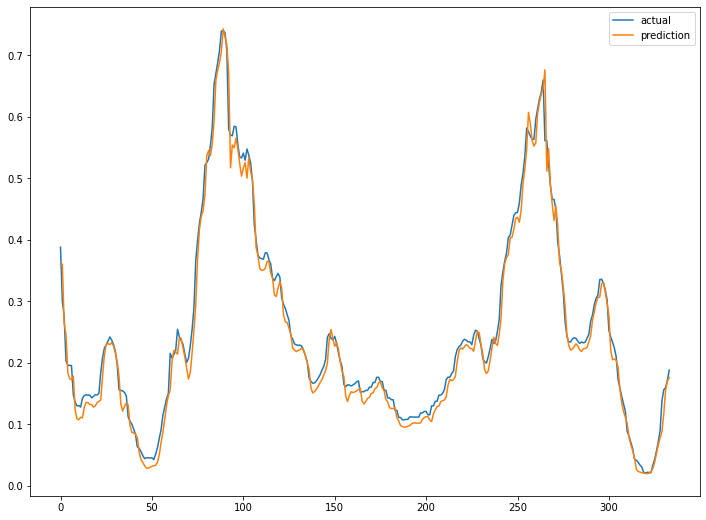

In [25]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [26]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

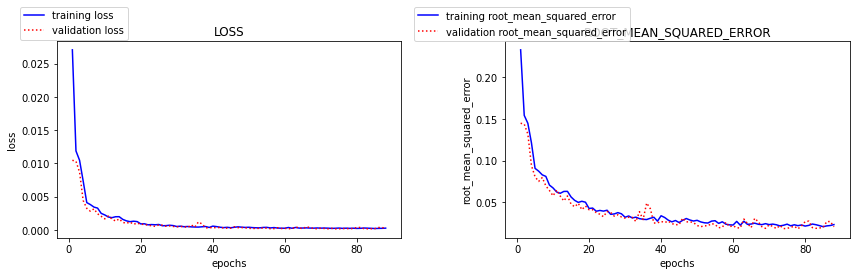

In [27]:
plot_history(history)

In [32]:
score=model.evaluate(x_test_t,y_test,batch_size=32)

12/12 [==============================] - 1s 7ms/step - loss: 0.0248 - root_mean_squared_error: 0.2225


In [28]:
import tensorflow.keras as keras
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)

In [29]:
import tensorflow.keras as keras
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)

In [30]:
model.save('onion(lstm)1.h5')

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

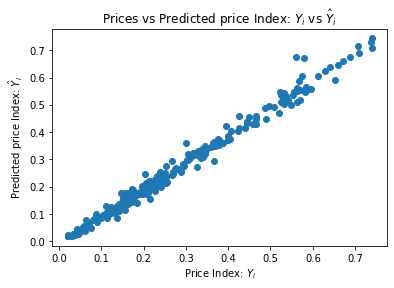

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(train_data, batch_size=32)
plt.scatter(y_test[20:], pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")